### <p style="text-align: right;"> &#9989; Ahmed Tawakol.</p>

# Homework Assignment #5 (Individual)

## Using SVMs and PCA with familiar data: The Iris Dataset

### Goals for this homework assignment

By the end of this assignment, you should be able to:
* Use `git` to track your work and turn in your assignment
* Read in data and prepare it for modeling
* Build, fit, and evaluate an SVC model of data
* Use PCA to reduce the number of important features
* Build, fit, and evaluate an SVC model of PCA-transformed data
* Systematically investigate the effects of the number of PCA components on an SVC model of data

### Assignment instructions:

Work through the following assignment, making sure to follow all of the directions and answer all of the questions.

There are **44 points (+2 bonus points)** possible on this assignment. Point values for each part are included in the section headers.

This assignment is **due at 11:59 pm on Friday, April 15. It should be pushed to your repo (see Part 1) and submitted to D2L**. 

#### Imports

It's useful to put all of the imports you need for this assignment in one place. Read through the assignment to figure out which imports you'll need or add them here as you go.

In [1]:
# Put all necessary imports here
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from ipywidgets import interact
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
import pickle
import time
from sklearn.decomposition import PCA

---
## 1. Add to your Git repository to track your progress on your assignment (4 points)

As usual, for this assignment, you're going to add it to the `cmse202-s21-turnin` repository you created in class so that you can track your progress on the assignment and preserve the final version that you turn in. In order to do this you need to

**&#9989; Do the following**:

1. Navigate to your `cmse202-s21-turnin` repository and create a new directory called `hw-05`.
2. Move this notebook into that **new directory** in your repository, then **add it and commit it to your repository**.
1. Finally, to test that everything is working, "git push" the file so that it ends up in your GitHub repository.

**Important**: Make sure you've added your Professor and your TA as collaborators to your "turnin" respository with "Read" access so that we can see your assignment (you should have done this in the previous homework assignment)

**Also important**: Make sure that the version of this notebook that you are working on is the same one that you just added to your repository! If you are working on a different copy of the noteobok, **none of your changes will be tracked**!

If everything went as intended, the file should now show up on your GitHub account in the "`cmse202-s21-turnin`" repository inside the `hw-05` directory that you just created.  Periodically, **you'll be asked to commit your changes to the repository and push them to the remote GitHub location**. Of course, you can always commit your changes more often than that, if you wish.  It can be good to get into a habit of committing your changes any time you make a significant modification, or when you stop working on the project for a bit.

&#9989; **Do this**: Before you move on, put the command that your instructor should run to clone your repository in the markdown cell below.

In [2]:
!git clone https://github.com/ahmedtawakol/cmse202-s21-turnin

fatal: destination path 'cmse202-s21-turnin' already exists and is not an empty directory.


---
<a id="loading"></a>
## 2. Loading a familiar dataset: The iris data (6 points)

We've the seen the iris dataset a number of times in the course so far, and since the goal for this assignment is to practice using the SVM and PCA tools we've covered in class, we'll stick with using this simple dataset and avoid any complicated data wrangling headaches. As a reminder: you can find details about the dataset <a href="https://en.wikipedia.org/wiki/Iris_flower_data_set">here</a>. 
 
#### The Iris data

As we've seen, the iris data set is pretty straight forward. Rather than working with a perfectly curated data set though, we'll use the same version of the data that we first looked at during the **Day 6 in-class activity**.

**&#9989; Do This:**  To get started, **you'll need to download the following two files** (or located them from when you used them previously):

`https://raw.githubusercontent.com/msu-cmse-courses/cmse202-S21-student/master/data/iris.data`

`https://raw.githubusercontent.com/msu-cmse-courses/cmse202-S21-student/master/data/iris.names`

Once you've downloaded the data or copied it over from where your saved it previously, you should have access to the following : `iris.data` and `iris.names`.

**Open the files using a text browser or other tool on your computer and confirm that they match your expectations and contain the data that we've worked with before.**

### 2.1 Load the data

**&#9989; Task 2.1 (2 points):** Read the ```iris.data``` file into your notebook **with appropriate column headers**. Since we are planning on classifying the data, you should label the fifth column `class`, which should have the iris species class labels:
* "Iris-setosa"
* "Iris-versicolor"
* "Iris-virginica"

Display the DataFrame to make sure it looks reasonable. You should have **5 columns** and **150 rows**.

In [3]:
data = pd.read_csv("iris.data", delimiter = " ", names = ["sepal length in cm", "sepal width in cm", "petal length in cm", "petal width in cm","class"])

### 2.2 Relabeling the classes

To simplify the process of modeling the iris data, we should convert the class labels from strings to integers. For example, rather than `Iris-setosa`, we can consider this to be class "`0`".

**&#9989; Task 2.2 (2 points):** Replace all of the strings in your "class" column with integers based on the following:

| original label | replaced label |
| -------- | -------- |
| Iris-setosa | 0 |
| Iris-versicolor | 1 |
| Iris-virginica | 2 |

Once you've replaced the labels, display your DataFrame and confirm that it looks correct.

In [4]:
data = data.replace("Iris-setosa",0)
data = data.replace("Iris-versicolor",1)
data = data.replace("Iris-virginica",2)
data

,sepal length in cm,sepal width in cm,petal length in cm,petal width in cm,class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


### 2.3 Separating the "features" from the "labels"

As we've seen when working with `sklearn` it can be much easier to work with the data if we have separate variables that store the features and the labels.

**&#9989; Task 2.3 (1 point):** Split your DataFrame so that you have two separate DataFrames, one called `features`, which contains all of the iris features, and one called `labels`, which contains all of the *new* iris integer labels you just created.

In [5]:
features = data.drop(axis = 1, columns = "class")
labels = data["class"]

&#9989; **Question 2.1 (1 point):** How balanced is your set of iris classes? Does it matter for the set of classes to be balanced? Why or why not?

<font size=+3>&#9998;</font> The data set is very balanced with each type of iris being represented by 50 rows. Generally you dont want your data to be very unbalanced. 

---
### &#128721; STOP
**Pause to commit your changes to your Git repository!**

Take a moment to save your notebook, commit the changes to your Git repository using the commit message "Committing Part 2", and push the changes to GitHub.

---

---
## 3. Building an SVC model (4 points)

Now, to tackle this classification problem, we will use a support vector machine just like we've done previously (e.g. in the **Day 19 and Day 20 assignments**). Of course, we could easily replace this with any `sklearn` classifier we choose, but for now we will just use an SVC with a linear kernel.

### 3.1 Splitting the data

But first, we need to split our data into training and testing data!

**&#9989; Task 3.1 (1 point):** Split your data into a training and testing set with a training set representing 75% of your data. For reproducibility , set the `random_state` argument to `314159`. Print the lengths to show you have the right number of entries.

In [6]:
train_vectors, test_vectors, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 314159)
print("train size = ", len(train_vectors))
print("test size = ", len(test_vectors))

train size =  112
test size =  38


### 3.2 Modeling the data and evaluating the fit

As you have done this a number of times at this point, we ask you to do most of the analysis for this problem in one cell.

**&#9989; Task 3.2 (2 points):** Build a linear SVC model with `C=0.01`, fit it to the training set, and use the test features to predict the outcomes. Evaluate the fit using the **confusion matrix** and **classification report**.

**Note:** Double-check the documentation on the confusion matrix because the way `sklearn` outputs false positives and false negatives may be different from what most images on the web indicate.

In [7]:
pre = SVC(C = 0.01, kernel = "linear")
pre.fit(train_vectors, train_labels)
pred_labels = pre.predict(test_vectors)
print(classification_report(test_labels, pred_labels))
print(confusion_matrix(test_labels, pred_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       0.79      0.92      0.85        12
           2       0.90      0.75      0.82        12

    accuracy                           0.89        38
   macro avg       0.90      0.89      0.89        38
weighted avg       0.90      0.89      0.89        38

[[14  0  0]
 [ 0 11  1]
 [ 0  3  9]]


&#9989; **Question 3.1 (1 point):** How accurate is your model? What evidence are you using to determine that? How many false positives and false negatives does it predict?

<font size=+3>&#9998;</font> 89% accurate, 4 misclasifications

---
### &#128721; STOP
**Pause to commit your changes to your Git repository!**

Take a moment to save your notebook, commit the changes to your Git repository using the commit message "Committing Part 3", and push the changes to GitHub.

---

---
## 4. Finding and using the best hyperparameters (8 points)

At this point, we have fit one model and determined it's performance, but is it the best model? We can use `GridSearchCV` to find the best model (given our choices of parameters). Once we do that, we will use that best model going forward. This is similar to what we did when working with the "digits" data and the "faces" data in the **Day 20 and Day 21 assignments**.

**Note:** you would typically rerun this grid search in a production environment to continue to verify the best model, but we are not for the sake of speed.

### 4.1 Performing a grid search

**&#9989; Task 4.1 (4 points):** Using the following parameters (`C` = `1e-3`, `0.01`, `0.1`, `1`, `10`, `100` and `gamma` = `1e-6`, `1e-5`, `1e-4`, `1e-3`, `0.01`, `0.1`) for both a `linear` and `rbf` kernel use `GridSearchCV` with the `SVC()` model to find the best fit parameters. Once, you're run the grid search, print the "best estimators".

In [8]:
start = time.time()
tmp_vectors = train_vectors
tmp_labels = train_labels

param_grid = {'C': [1e-3, 0.01, 0.1, 1, 10, 100],
              'gamma': [1e-6, 1e-5, 1e-4, 1e-3, 0.01, 0.1],
              'kernel': ['linear','rbf']}
clf = GridSearchCV(SVC(), param_grid)
clf = clf.fit(tmp_vectors, tmp_labels)
print("Best estimator found by grid search:")
print(clf.best_estimator_)
print("Best parameters found by grid search:")
print(clf.best_params_)

end = time.time()
print("Runtime",end - start)

Best estimator found by grid search:
SVC(C=10, gamma=1e-06, kernel='linear')
Best parameters found by grid search:
{'C': 10, 'gamma': 1e-06, 'kernel': 'linear'}
Runtime 1.0623767375946045


&#9989; **Question 4.1 (1 point):** How do the "best estimator" results of the grid search compare to what you used in Part 3? Did the hyper parameter(s) change? What kernel did the grid search determine was the best option? 

<font size=+3>&#9998;</font> 'C': 10, 'gamma': 1e-06, 'kernel': 'linear' its 6% more accurate 

### 4.2 Evaluating the best fit model

Now that we have found the "best estimators", let's determine how good the fit is.

**&#9989; Task 4.2 (2 points):** Use the test features to predict the outcomes for the best model. Evaluate the fit using the **confusion matrix** and **classification report**.

**Note:** Double-check the documentation on the confusion matrix because the way `sklearn` outputs false positives and false negatives may be different from what most images on the web indicate.

In [9]:
pre = SVC(C = 10, gamma = 1e-06, kernel = 'linear')
pre.fit(train_vectors, train_labels)
pred_labels = pre.predict(test_vectors)
print(classification_report(test_labels, pred_labels))
print(confusion_matrix(test_labels, pred_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      0.83      0.91        12
           2       0.86      1.00      0.92        12

    accuracy                           0.95        38
   macro avg       0.95      0.94      0.94        38
weighted avg       0.95      0.95      0.95        38

[[14  0  0]
 [ 0 10  2]
 [ 0  0 12]]


&#9989; **Question 4.2 (1 point):** How accurate is this best model? What evidence are you using to determine that? How many false positives and false negatives does it predict?

<font size=+3>&#9998;</font> 95% accurate throughh the classification matrix. There are 2 missclassifications

---
### &#128721; STOP
**Pause to commit your changes to your Git repository!**

Take a moment to save your notebook, commit the changes to your Git repository using the commit message "Committing Part 4", and push the changes to GitHub.

---

---
## 5. Using Principal Components (10 points)

The full model uses all 4 iris features to predict the results and you likely found that the model is pretty accurate using all 4 features. But in some cases, we might have significantly more features (which means much more computational time!), and we might not need nearly the level of accuracy we can achieve with the full data set or we might not have enough computational resources to use **all** of the features.

In such situations, we might need to see how close we can get with fewer features. But instead of simply removing features, we will use a PCA to determine the features that contribute the most the model (through their accounted variance) and use those to build our SVC model. We did this to improve our classification with the "faces" dataset in the **Day 21 assignment**.

### 5.1 Running a Principle Component Analysis (PCA)

Since we only have 4 total features to start with, let's see how well we can do if we try to cut this aggressively reduce the feature count and use only **1** principle component. We'll see how well we can predict the classes of the iris dataset with just these two!

**&#9989; Task 5.1 (3 points):**  Using `PCA()` and the associated `fit()` method, run a principle component analysis to your training features using only 2 components. Transform both the test and training features using the result of your PCA. Print the `explained_variance_ratio_`.

In [10]:
pca = PCA(n_components = 1)

pca.fit(train_vectors)
pca_train_vectors = pca.transform(train_vectors)
pca_test_vectors = pca.transform(test_vectors)
print("for 1", pca.explained_variance_ratio_[0])

for 1 0.9232169568032699


&#9989; **Question 5.1 (1 point):** What is the total explained variance ratio captured by this simple 1-component PCA? (just quote the number) How well do you think a model with this many feature will perform? Why?

<font size=+3>&#9998;</font> 0.9232169568032699. It will perform better because its close to 1.

### 5.2 Fit and Evaluate an SVC model

Using the pca transformed features, we will train and test an SVC model using the "best estimators" you found previously.

**&#9989; Task 5.2 (2 points):**  Using the PCA transformed training data, build and train an SVC model using the best estimate values from before. Predict the classes using the PCA transformed test data. Evaluate the model using the classfication report, and the confusion matrix.

In [11]:
pra = SVC(C = 10, gamma = 1e-06, kernel = 'linear')
pra.fit(pca_train_vectors, train_labels)
pre_labels = pra.predict(pca_test_vectors)
print(classification_report(test_labels, pre_labels))
print(confusion_matrix(test_labels, pre_labels))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      0.75      0.86        12
           2       0.80      1.00      0.89        12

    accuracy                           0.92        38
   macro avg       0.93      0.92      0.92        38
weighted avg       0.94      0.92      0.92        38

[[14  0  0]
 [ 0  9  3]
 [ 0  0 12]]


&#9989; **Question 5.2 (1 point):** How accurate is this model? What evidence are you using to determine that? How many false positives and false negatives does it predict? How does it compare to the full feature model?

<font size=+3>&#9998;</font> 92% accurate. the classification matric there are 3 miserrors

### 5.3 Repeat your analysis with more components

You probably found that the model with just 1 features didn't actually do too bad, which is pretty impressive. That said, can we do better?

What if we increase the number of principle components to **2**? What happens now?

**&#9989; Task 5.3 (2 points):** Repeat your analysis from 5.1 and 5.2 using **2 components** instead. As part of your analysis, **print the total explained variance ratio for both components as well as the sum of these values**.

In [22]:
pca = PCA(n_components = 2)

pca.fit(train_vectors)
pca_train_vectors = pca.transform(train_vectors)
print(pca.explained_variance_ratio_)

pca_test_vectors = pca.transform(test_vectors)

pra = SVC(C = 10, gamma = 1e-06, kernel = 'linear')
pra.fit(pca_train_vectors, train_labels)
pre_labels = pra.predict(pca_test_vectors)
print(classification_report(test_labels, pre_labels))
print(confusion_matrix(test_labels, pre_labels))
print("sum of TEV: ",sum(pca.explained_variance_ratio_))

[0.92321696 0.05442265]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      0.92      0.96        12
           2       0.92      1.00      0.96        12

    accuracy                           0.97        38
   macro avg       0.97      0.97      0.97        38
weighted avg       0.98      0.97      0.97        38

[[14  0  0]
 [ 0 11  1]
 [ 0  0 12]]
sum of TEV:  0.9776396024180721


&#9989; **Question 5.3 (1 point):** What is the total explained variance ratio captured by this PCA? How accurate is this model? What evidence are you using to determine that? How many false positives and false negatives does it predict? How does it compare to the 1 PCA component model? To the full feature model?

<font size=+3>&#9998;</font> 0.9232169568032699. this model was 97% accurate, there was only misscalculation which is much better when in comparison to the other models. 

---
### &#128721; STOP
**Pause to commit your changes to your Git repository!**

Take a moment to save your notebook, commit the changes to your Git repository using the commit message "Committing Part 5", and push the changes to GitHub.

---

---
## 6. How well does PCA work? (12 points)

Clearly, the number of components we use in our PCA matters. Let's investigate how they matter by systematically building a model for any number of selected components. While this might seem a bit unnecessary for such a simple dataset, **this can be very useful for more complex datasets and models!**

### 6.1 Accuracy vs. Components

To systematically explore how well PCA improves our classification model, we will do this by writing a function that creates the PCA, the SVC model, fits the training data, predict the labels using test data, and returns the accuracy scores and the explained variance ratio. So your function will take as input:
* the number of request PCA components
* the training feature data
* the testing feature data
* the training data labels
* the test data labels
and it will return the accuracy score for an SVC model fit to pca transformed features and the **total** explained variance ratio.

**&#9989; Task 6.1 (4 points):** Create this function, which you will use in the next section.

In [27]:
def improv(n_components, train_vectors, test_vectors, train_labels, test_labels):
    
    f = PCA(n_components = n_components)
    f.fit(train_vectors,train_labels)
    
    f_train_vectors = f.transform(train_vectors)
    f_test_vectors = f.transform(test_vectors)
    
    z = SVC(C = 10, gamma = 1e-06, kernel = 'linear')
    z.fit(f_train_vectors, train_labels)
    pre_labels = z.predict(f_test_vectors)
    
    score = accuracy_score(test_labels, pre_labels)
    ratio = sum(f.explained_variance_ratio_)
    return score, ratio 

### 6.2 Compute accuracies

Now that you have created a function that returns the accuracy for a given number of components, we will use that to plot the how the accuracy of your SVC model changes when we increase the number of components used in the PCA.

**&#9989; Task 6.2 (2 points):** For 1 through 4 components, use your function above to compute and store (as a list) the accuracy of your models and the total explained variance ratio of your models.

In [28]:
tests = []
rat = []
for i in range(1,5):
    accuracy , ratio = improv(i,train_vectors, test_vectors, train_labels, test_labels)
    tests.append(accuracy)
    rat.append(ratio)
print(tests, rat)

[0.9210526315789473, 0.9736842105263158, 0.9473684210526315, 0.9473684210526315] [0.9232169568032699, 0.9776396024180721, 0.9950883014071383, 1.0]


### 6.3 Plot accuracy vs number of components

Now that we have those numbers, it makes sense to look at the accuracy vs # of components.

**&#9989; Task 6.3 (2 points):** Plot the accuracy vs # of components.

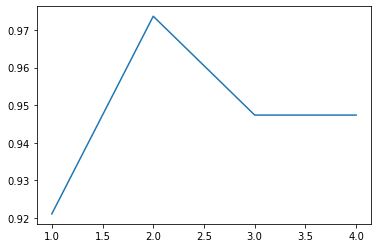

In [36]:
nc = [1,2,3,4]
plt.plot(nc, tests)

**&#9989; Question 6.1 (1 point):** Where does it seem like we have diminishing returns? That is, at what point is there no major increase in accuracy (or perhaps the accuracy is decreased) as we add additional components to the PCA?

<font size=+3>&#9998;</font> after 2 components

### 6.4 Plot total explained variance vs number of components

What if we look at total explained variance as a function of # of components?

**&#9989; Task 6.4 (2 points):** Plot the total explained variance ratio vs # of components. 

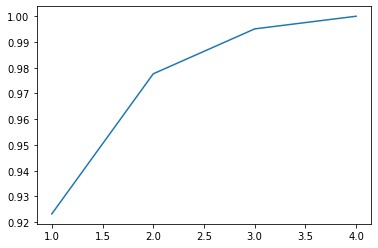

In [37]:
nc = [1,2,3,4]
plt.plot(nc, rat)

**&#9989; Question 6.2 (1 points):** Where does it seem like we have diminishing returns, that is, no major increase in explained variance as we add additional components to the PCA? How does that number of components compare to the diminishing returns for accuracy?

<font size=+3>&#9998;</font> No diminishing returns

---
### &#128721; STOP
**Pause to commit your changes to your Git repository!**

Take a moment to save your notebook, commit the changes to your Git repository using the commit message "Committing Part 6", and push the changes to GitHub.

---

---
## 7. Bonus exercise: visualizing the decision boundaries for a portion of the feature space (2 *bonus* points)

As you might imagine, visualizing decision boundaries with for a multidimensional feature space can be a challenge! That said, when trying to build some intuition about how these classifiers work, visualing 2D decisions boundaries can be useful.

To earn some _extra points_ on this assignment try using the [following example](https://scikit-learn.org/stable/auto_examples/svm/plot_iris_svc.html) as a guide to visualize the decision boundary for your "best estimator" parameters using your **2 PCA components** as your training features. **To be clear, you should be using your PCA component data and your best fit parameters, you should not just be running the example!** You should be able to get a plot that looks something like this:

<img src="https://i.ibb.co/wL4xHGb/pca-boundaries.png" alt="pca-boundaries" border="0">

Since we didn't explicitly cover this in class, **you do not have to complete this part of the assignment unless you would like the extra credit points**.

**&#9989; Task 7.1 (2 *extra* points):** Try to create a plot of the decision boundaries for the 2 principle components using your "best estimator" parameters.

---
## Assignment wrap-up¶
Please fill out the form that appears when you run the code below. **You must completely fill this out in order to receive credit for the assignment!**

In [18]:
from IPython.display import HTML
HTML(
"""
<iframe 
	src="https://forms.office.com/Pages/ResponsePage.aspx?id=MHEXIi9k2UGSEXQjetVofddd5T-Pwn1DlT6_yoCyuCFUNFFCRjgzN0JOTUFJQVNLR0VMQUZNNlVCTy4u" 
	width="800px" 
	height="600px" 
	frameborder="0" 
	marginheight="0" 
	marginwidth="0">
	Loading...
</iframe>
"""
)

### Congratulations, you're done!
Submit this assignment by uploading it to the course Desire2Learn web page. Go to the "Homework Assignments" folder, find the submission folder for Homework #5, and upload your notebook.